# Regularization

Deep Learning models have so much flexibility and capacity that **overfitting can be a serious problem**, if the training dataset is not big enough. 


* L2 regularization and Dropout are two very effective regularization techniques.    
* Regularization will help reduce overfitting.    
* Regularization will drive weights to lower values.    
* Apply dropout both during forward and backward propagation.    
* During training time, divide each dropout layer by keep_prob to keep the same expected value for the activations.   


**Here are the results of the three models**: 

<table> 
    <tr>
        <td>
        <b>model</b>
        </td>
        <td>
        <b>train accuracy</b>
        </td>
        <td>
        <b>test accuracy</b>
        </td>
    </tr>
        <td>
        3-layer NN without regularization
        </td>
        <td>
        95%
        </td>
        <td>
        91.5%
        </td>
    <tr>
        <td>
        3-layer NN with L2-regularization
        </td>
        <td>
        94%
        </td>
        <td>
        93%
        </td>
    </tr>
    <tr>
        <td>
        3-layer NN with dropout
        </td>
        <td>
        93%
        </td>
        <td>
        95%
        </td>
    </tr>
</table> 

## 1 - Packages

In [1]:
# import packages
import numpy as np
import matplotlib.pyplot as plt
import sklearn
import sklearn.datasets
import scipy.io
%matplotlib inline


## 2 - Problem Statement

Recommend positions where France's goal keeper should kick the ball so that the French team's players can then hit it with their head. 

<img src="images/field_kiank.png" style="width:600px;height:350px;">

<caption><center><font color='purple'><b>Figure 1</b>: Football field. The goal keeper kicks the ball in the air, the players of each team are fighting to hit the ball with their head </font></center></caption>

They give the following 2D dataset from France's past 10 games.

## 3 - Loading the Dataset

Each dot corresponds to a position on the football field where a football player has hit the ball with his/her head after the French goal keeper has shot the ball from the left side of the football field.
- If the dot is blue, it means the French player managed to hit the ball with his/her head
- If the dot is red, it means the other team's player hit the ball with their head

**Our goal**: Use a deep learning model to find the positions on the field where the goalkeeper should kick the ball.

**Analysis of the dataset**: This dataset is a little noisy, but it looks like a diagonal line separating the upper left half (blue) from the lower right half (red) would work well. 

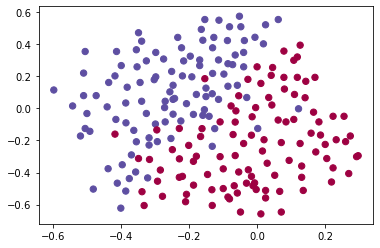

In [2]:
def load_2D_dataset():
    data = scipy.io.loadmat('data/nn_regularization/data.mat')
    train_X = data['X'].T
    train_Y = data['y'].T
    test_X = data['Xval'].T
    test_Y = data['yval'].T

    plt.scatter(train_X[0, :], train_X[1, :], c=train_Y, s=40, cmap=plt.cm.Spectral);
    
    return train_X, train_Y, test_X, test_Y

train_X, train_Y, test_X, test_Y = load_2D_dataset()

## 4 - Non-Regularized Model

This model can be used:
- in *regularization mode* -- by setting the `lambd` input to a non-zero value. We use "`lambd`" instead of "`lambda`" because "`lambda`" is a reserved keyword in Python. 
- in *dropout mode* -- by setting the `keep_prob` to a value less than one

We will first try the model without any regularization. Then, we will implement:
- *L2 regularization* -- functions: "`compute_cost_with_regularization()`" and "`backward_propagation_with_regularization()`"
- *Dropout* -- functions: "`forward_propagation_with_dropout()`" and "`backward_propagation_with_dropout()`"

## Helper Functions

In [3]:
def sigmoid(x):
    return 1/(1+np.exp(-x))

def relu(x):
    return np.maximum(0,x)

In [4]:
def initialize_parameters(layer_dims):
    np.random.seed(3)
    parameters = {}
    L = len(layer_dims) # number of layers in the network

    for l in range(1, L):
        parameters['W' + str(l)] = np.random.randn(layer_dims[l], layer_dims[l-1]) / np.sqrt(layer_dims[l-1])
        parameters['b' + str(l)] = np.zeros((layer_dims[l], 1))
        
    return parameters

In [5]:
def forward_propagation(X, parameters):
    """Implements the forward propagation."""
        
    # retrieve parameters
    W1 = parameters["W1"]
    b1 = parameters["b1"]
    W2 = parameters["W2"]
    b2 = parameters["b2"]
    W3 = parameters["W3"]
    b3 = parameters["b3"]
    
    # LINEAR -> RELU -> LINEAR -> RELU -> LINEAR -> SIGMOID
    Z1 = np.dot(W1, X) + b1
    A1 = relu(Z1)
    Z2 = np.dot(W2, A1) + b2
    A2 = relu(Z2)
    Z3 = np.dot(W3, A2) + b3
    A3 = sigmoid(Z3)
    
    cache = (Z1, A1, W1, b1, Z2, A2, W2, b2, Z3, A3, W3, b3)
    
    return A3, cache

In [6]:
def compute_cost(a3, Y):
    """
    a3 -- post-activation, output of forward propagation
    Y -- "true" labels vector, same shape as a3
    """
    m = Y.shape[1]
    
    logprobs = np.multiply(-np.log(a3),Y) + np.multiply(-np.log(1 - a3), 1 - Y)
    cost = 1./m * np.nansum(logprobs)
    
    return cost

In [7]:
def backward_propagation(X, Y, cache):
    """Implement the backward propagation."""
    m = X.shape[1]
    (Z1, A1, W1, b1, Z2, A2, W2, b2, Z3, A3, W3, b3) = cache
    
    dZ3 = A3 - Y
    dW3 = 1./m * np.dot(dZ3, A2.T)
    db3 = 1./m * np.sum(dZ3, axis=1, keepdims = True)
    
    dA2 = np.dot(W3.T, dZ3)
    dZ2 = np.multiply(dA2, np.int64(A2 > 0))
    dW2 = 1./m * np.dot(dZ2, A1.T)
    db2 = 1./m * np.sum(dZ2, axis=1, keepdims = True)
    
    dA1 = np.dot(W2.T, dZ2)
    dZ1 = np.multiply(dA1, np.int64(A1 > 0))
    dW1 = 1./m * np.dot(dZ1, X.T)
    db1 = 1./m * np.sum(dZ1, axis=1, keepdims = True)
    
    gradients = {"dZ3": dZ3, "dW3": dW3, "db3": db3,
                 "dA2": dA2, "dZ2": dZ2, "dW2": dW2, "db2": db2,
                 "dA1": dA1, "dZ1": dZ1, "dW1": dW1, "db1": db1}
    
    return gradients

In [8]:
def update_parameters(parameters, grads, learning_rate):
    n = len(parameters) // 2 # number of layers in the neural networks
    for k in range(n):
        parameters["W" + str(k+1)] = parameters["W" + str(k+1)] - learning_rate * grads["dW" + str(k+1)]
        parameters["b" + str(k+1)] = parameters["b" + str(k+1)] - learning_rate * grads["db" + str(k+1)]
        
    return parameters

In [9]:
def predict(X, y, parameters):
    m = X.shape[1]
    p = np.zeros((1,m), dtype = np.int64)
    
    # Forward propagation
    a3, caches = forward_propagation(X, parameters)
    
    # convert probas to 0/1 predictions
    for i in range(0, a3.shape[1]):
        if a3[0,i] > 0.5:
            p[0,i] = 1
        else:
            p[0,i] = 0

    print("Accuracy: "  + str(np.mean((p[0,:] == y[0,:]))))
    return p

In [10]:
def model(X, Y, learning_rate = 0.3, num_iterations = 30000, print_cost = True, lambd = 0, keep_prob = 1):
    """
    Implements a three-layer neural network: LINEAR->RELU->LINEAR->RELU->LINEAR->SIGMOID.
    
    Arguments:
    X -- input data, of shape (input size, number of examples)
    Y -- true "label" vector (1 for blue dot / 0 for red dot), of shape (output size, number of examples)
    learning_rate -- learning rate of the optimization
    num_iterations -- number of iterations of the optimization loop
    print_cost -- If True, print the cost every 10000 iterations
    lambd -- regularization hyperparameter, scalar
    keep_prob - probability of keeping a neuron active during drop-out, scalar.
    
    Returns:
    parameters -- parameters learned by the model. They can then be used to predict.
    """
        
    grads = {}
    costs = []                            # to keep track of the cost
    m = X.shape[1]                        # number of examples
    layers_dims = [X.shape[0], 20, 3, 1]
    
    # Initialize parameters dictionary.
    parameters = initialize_parameters(layers_dims)

    # Loop (gradient descent)
    for i in range(0, num_iterations):

        # Forward propagation: LINEAR -> RELU -> LINEAR -> RELU -> LINEAR -> SIGMOID.
        if keep_prob == 1:
            a3, cache = forward_propagation(X, parameters)
        elif keep_prob < 1:
            a3, cache = forward_propagation_with_dropout(X, parameters, keep_prob)
        
        # Cost function
        if lambd == 0:
            cost = compute_cost(a3, Y)
        else:
            cost = compute_cost_with_regularization(a3, Y, parameters, lambd)
            
        # Backward propagation.
        assert (lambd == 0 or keep_prob == 1)   # it is possible to use both L2 regularization and dropout, 
                                                # but this assignment will only explore one at a time
        if lambd == 0 and keep_prob == 1:
            grads = backward_propagation(X, Y, cache)
        elif lambd != 0:
            grads = backward_propagation_with_regularization(X, Y, cache, lambd)
        elif keep_prob < 1:
            grads = backward_propagation_with_dropout(X, Y, cache, keep_prob)
        
        # Update parameters.
        parameters = update_parameters(parameters, grads, learning_rate)
        
        # Print the loss every 10000 iterations
        if print_cost and i % 10000 == 0:
            print("Cost after iteration {}: {}".format(i, cost))
        if print_cost and i % 1000 == 0:
            costs.append(cost)
    
    # plot the cost
    plt.plot(costs)
    plt.ylabel('cost')
    plt.xlabel('iterations (x1,000)')
    plt.title("Learning rate =" + str(learning_rate))
    plt.show()
    
    return parameters

Let's train the model without any regularization, and observe the accuracy on the train/test sets.

Cost after iteration 0: 0.6557412523481002
Cost after iteration 10000: 0.1632998752572419
Cost after iteration 20000: 0.13851642423239133


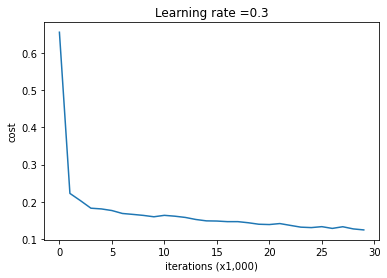

On the training set:
Accuracy: 0.9478672985781991
On the test set:
Accuracy: 0.915


In [11]:
parameters = model(train_X, train_Y)
print ("On the training set:")
predictions_train = predict(train_X, train_Y, parameters)
print ("On the test set:")
predictions_test = predict(test_X, test_Y, parameters)

The train accuracy is 94.8% while the test accuracy is 91.5%. This is the **baseline model**.

In [12]:
def plot_decision_boundary(model, X, y):
    # Set min and max values and give it some padding
    x_min, x_max = X[0, :].min() - 1, X[0, :].max() + 1
    y_min, y_max = X[1, :].min() - 1, X[1, :].max() + 1
    h = 0.01
    # Generate a grid of points with distance h between them
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    # Predict the function value for the whole grid
    Z = model(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    # Plot the contour and training examples
    plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral)
    plt.ylabel('x2')
    plt.xlabel('x1')
    plt.scatter(X[0, :], X[1, :], c=y, cmap=plt.cm.Spectral)
    plt.show()

def predict_dec(parameters, X):
    # Predict using forward propagation and a classification threshold of 0.5
    a3, cache = forward_propagation(X, parameters)
    predictions = (a3>0.5)
    return predictions

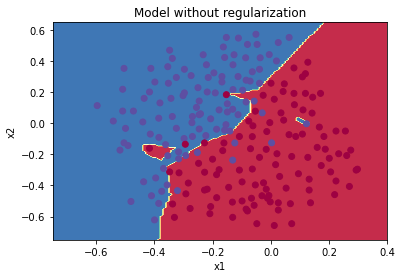

In [13]:
plt.title("Model without regularization")
axes = plt.gca()
axes.set_xlim([-0.75,0.40])
axes.set_ylim([-0.75,0.65])
plot_decision_boundary(lambda x: predict_dec(parameters, x.T), train_X, train_Y)

The non-regularized model is obviously overfitting the training set. It is fitting the noisy points! Lets now look at two techniques to reduce overfitting.

## 5 - L2 Regularization

The standard way to avoid overfitting is called **L2 regularization**. It consists of appropriately modifying the cost function, from:
$$J = -\frac{1}{m} \sum\limits_{i = 1}^{m} \large{(}\small  y^{(i)}\log\left(a^{[L](i)}\right) + (1-y^{(i)})\log\left(1- a^{[L](i)}\right) \large{)} \tag{1}$$
To:
$$J_{regularized} = \small \underbrace{-\frac{1}{m} \sum\limits_{i = 1}^{m} \large{(}\small y^{(i)}\log\left(a^{[L](i)}\right) + (1-y^{(i)})\log\left(1- a^{[L](i)}\right) \large{)} }_\text{cross-entropy cost} + \underbrace{\frac{1}{m} \frac{\lambda}{2} \sum\limits_l\sum\limits_k\sum\limits_j W_{k,j}^{[l]2} }_\text{L2 regularization cost} \tag{2}$$

Because we change the cost, we have to change backward propagation as well! All the gradients have to be computed with respect to this new cost. 

In [14]:
def compute_cost_with_regularization(A3, Y, parameters, lambd):
    """
    Implement the cost function with L2 regularization. See formula (2) above.
    
    Arguments:
    A3 -- post-activation, output of forward propagation, of shape (output size, number of examples)
    Y -- "true" labels vector, of shape (output size, number of examples)
    parameters -- python dictionary containing parameters of the model
    
    Returns:
    cost - value of the regularized loss function (formula (2))
    """
    m = Y.shape[1]
    W1 = parameters["W1"]
    W2 = parameters["W2"]
    W3 = parameters["W3"]
    
    cross_entropy_cost = compute_cost(A3, Y) # This gives you the cross-entropy part of the cost
    L2_regularization_cost = (0.5*lambd/m)*(np.sum(W1**2) + np.sum(W2**2) + np.sum(W3**2))
    cost = cross_entropy_cost + L2_regularization_cost
    
    return cost

In [15]:
def backward_propagation_with_regularization(X, Y, cache, lambd):
    m = X.shape[1]
    (Z1, A1, W1, b1, Z2, A2, W2, b2, Z3, A3, W3, b3) = cache
    
    dZ3 = A3 - Y
    dW3 = (1./m) * np.dot(dZ3, A2.T) + (lambd/m)*W3
    db3 = 1. / m * np.sum(dZ3, axis=1, keepdims=True)
    
    dA2 = np.dot(W3.T, dZ3)
    dZ2 = np.multiply(dA2, np.int64(A2 > 0))
    dW2 = 1./m * np.dot(dZ2, A1.T) + (lambd/m)*W2
    db2 = 1. / m * np.sum(dZ2, axis=1, keepdims=True)

    dA1 = np.dot(W2.T, dZ2)
    dZ1 = np.multiply(dA1, np.int64(A1 > 0))
    dW1 = 1./m * np.dot(dZ1, X.T) + (lambd/m)*W1
    db1 = 1. / m * np.sum(dZ1, axis=1, keepdims=True)
    
    gradients = {"dZ3": dZ3, "dW3": dW3, "db3": db3,"dA2": dA2,
                 "dZ2": dZ2, "dW2": dW2, "db2": db2, "dA1": dA1, 
                 "dZ1": dZ1, "dW1": dW1, "db1": db1}
    
    return gradients

Cost after iteration 0: 0.6974484493131264
Cost after iteration 10000: 0.2684918873282239
Cost after iteration 20000: 0.2680916337127301


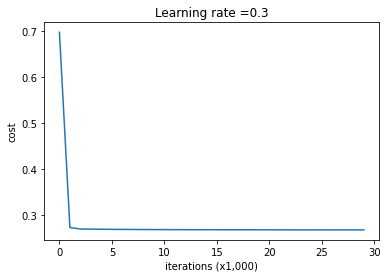

On the train set:
Accuracy: 0.9383886255924171
On the test set:
Accuracy: 0.93


In [16]:
parameters = model(train_X, train_Y, lambd = 0.7)
print ("On the train set:")
predictions_train = predict(train_X, train_Y, parameters)
print ("On the test set:")
predictions_test = predict(test_X, test_Y, parameters)

The test accuracy improved from 91.5% to 93%

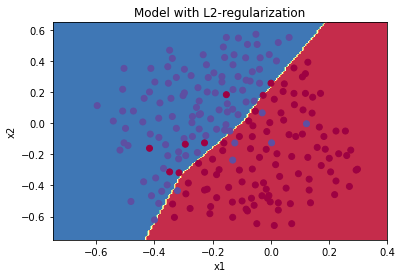

In [17]:
plt.title("Model with L2-regularization")
axes = plt.gca()
axes.set_xlim([-0.75,0.40])
axes.set_ylim([-0.75,0.65])
plot_decision_boundary(lambda x: predict_dec(parameters, x.T), train_X, train_Y)

## 6 - Dropout

Finally, **dropout** is a widely used regularization technique that is specific to deep learning. 
**It randomly shuts down some neurons in each iteration.** 

<!--
To understand drop-out, consider this conversation with a friend:
- Friend: "Why do you need all these neurons to train your network and classify images?". 
- You: "Because each neuron contains a weight and can learn specific features/details/shape of an image. The more neurons I have, the more featurse my model learns!"
- Friend: "I see, but are you sure that your neurons are learning different features and not all the same features?"
- You: "Good point... Neurons in the same layer actually don't talk to each other. It should be definitly possible that they learn the same image features/shapes/forms/details... which would be redundant. There should be a solution."
!--> 

<center>
<video width="620" height="440" src="images/dropout1_kiank.mp4" type="video/mp4" controls>
</video>
</center>
<br>
<caption><center><font color='purple'><b>Figure 2 </b>: <b>Drop-out on the second hidden layer.</b> <br> At each iteration, you shut down (= set to zero) each neuron of a layer with probability $1 - keep\_prob$ or keep it with probability $keep\_prob$ (50% here). The dropped neurons don't contribute to the training in both the forward and backward propagations of the iteration. </font></center></caption>

<center>
<video width="620" height="440" src="images/dropout2_kiank.mp4" type="video/mp4" controls>
</video>
</center>

<caption><center><font color='purple'><b>Figure 3</b>:<b> Drop-out on the first and third hidden layers. </b><br> $1^{st}$ layer: we shut down on average 40% of the neurons.  $3^{rd}$ layer: we shut down on average 20% of the neurons. </font></center></caption>


When we shut some neurons down, we actually modify the model. The idea behind drop-out is that at each iteration, we train a different model that uses only a subset of neurons. With dropout, these neurons thus become less sensitive to the activation of one other specific neuron, because that other neuron might be shut down at any time. 


**Backpropagation**:
Backpropagation with dropout is actually quite easy.
1. We had previously shut down some neurons during forward propagation, by applying a mask $D^{[1]}$ to `A1`. In backpropagation, we will have to shut down the same neurons, by reapplying the same mask $D^{[1]}$ to `dA1`. 
2. During forward propagation, we had divided `A1` by `keep_prob`. In backpropagation, we'll therefore have to divide `dA1` by `keep_prob` again (the calculus interpretation is that if $A^{[1]}$ is scaled by `keep_prob`, then its derivative $dA^{[1]}$ is also scaled by the same `keep_prob`).

In [18]:
def forward_propagation_with_dropout(X, parameters, keep_prob = 0.5):
    np.random.seed(1)
    
    # retrieve parameters
    W1 = parameters["W1"]
    b1 = parameters["b1"]
    W2 = parameters["W2"]
    b2 = parameters["b2"]
    W3 = parameters["W3"]
    b3 = parameters["b3"]
    
    # LINEAR -> RELU -> LINEAR -> RELU -> LINEAR -> SIGMOID
    Z1 = np.dot(W1, X) + b1
    A1 = relu(Z1)
    
    # Dropout
    D1 = np.random.rand(A1.shape[0], A1.shape[1])
    D1 = (D1<keep_prob).astype(int)
    A1 = A1 * D1
    A1 = A1/keep_prob

    Z2 = np.dot(W2, A1) + b2
    A2 = relu(Z2)
    
    # Dropout
    D2 = np.random.rand(A2.shape[0],A2.shape[1])
    D2 = (D2<keep_prob).astype(int)
    A2 = A2 * D2
    A2 = A2/keep_prob
    
    Z3 = np.dot(W3, A2) + b3
    A3 = sigmoid(Z3)
    
    cache = (Z1, D1, A1, W1, b1, Z2, D2, A2, W2, b2, Z3, A3, W3, b3)
    
    return A3, cache

In [19]:
def backward_propagation_with_dropout(X, Y, cache, keep_prob):   
    m = X.shape[1]
    (Z1, D1, A1, W1, b1, Z2, D2, A2, W2, b2, Z3, A3, W3, b3) = cache
    
    dZ3 = A3 - Y
    dW3 = 1./m * np.dot(dZ3, A2.T)
    db3 = 1./m * np.sum(dZ3, axis=1, keepdims=True)
    dA2 = np.dot(W3.T, dZ3)
    
    dA2 = dA2 * D2
    dA2 = dA2 / keep_prob
    dZ2 = np.multiply(dA2, np.int64(A2 > 0))
    
    dW2 = 1./m * np.dot(dZ2, A1.T)
    db2 = 1./m * np.sum(dZ2, axis=1, keepdims=True)
    
    dA1 = np.dot(W2.T, dZ2)
    
    dA1 = dA1 * D1
    dA1 = dA1 / keep_prob
    dZ1 = np.multiply(dA1, np.int64(A1 > 0))
    
    dW1 = 1./m * np.dot(dZ1, X.T)
    db1 = 1./m * np.sum(dZ1, axis=1, keepdims=True)
    
    gradients = {"dZ3": dZ3, "dW3": dW3, "db3": db3,"dA2": dA2,
                 "dZ2": dZ2, "dW2": dW2, "db2": db2, "dA1": dA1, 
                 "dZ1": dZ1, "dW1": dW1, "db1": db1}
    
    return gradients

Cost after iteration 0: 0.6543912405149825


C:\Users\uditg\AppData\Local\Temp\ipykernel_6432\205091431.py:8: RuntimeWarning: divide by zero encountered in log
  logprobs = np.multiply(-np.log(a3),Y) + np.multiply(-np.log(1 - a3), 1 - Y)
C:\Users\uditg\AppData\Local\Temp\ipykernel_6432\205091431.py:8: RuntimeWarning: invalid value encountered in multiply
  logprobs = np.multiply(-np.log(a3),Y) + np.multiply(-np.log(1 - a3), 1 - Y)


Cost after iteration 10000: 0.061016986574905605
Cost after iteration 20000: 0.060582435798513114


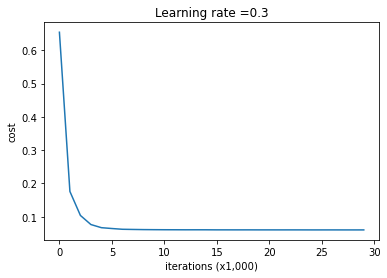

On the train set:
Accuracy: 0.9289099526066351
On the test set:
Accuracy: 0.95


In [20]:
parameters = model(train_X, train_Y, keep_prob = 0.86, learning_rate = 0.3)

print ("On the train set:")
predictions_train = predict(train_X, train_Y, parameters)
print ("On the test set:")
predictions_test = predict(test_X, test_Y, parameters)

Dropout works great! The test accuracy has increased again (to 95%)!

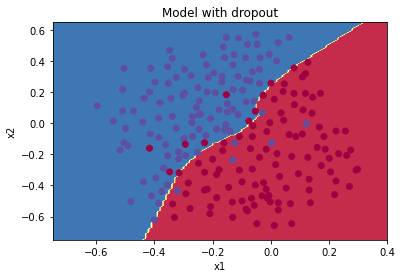

In [21]:
plt.title("Model with dropout")
axes = plt.gca()
axes.set_xlim([-0.75,0.40])
axes.set_ylim([-0.75,0.65])
plot_decision_boundary(lambda x: predict_dec(parameters, x.T), train_X, train_Y)